# Exploration of R3D data computed with full polarisation matrices in kappa

## Extra codes

e.g. Create gas-kappa-file with empty scatmat-matrix

In [2]:
# Write empty kappascatmat-file for usage for gas
# or other medium with no scattering.
#
# File to compare with
# r3dsims/dustkapscatmat_mg2sio4_1.416e-01.inp
# name new file: dustkapscatmat_opastar.inp
#
# header
# 1, 1000, 181 (one species, 1000 wavelengths, 181 angles)
#
# 4 columns, 1000 long - wavelength(um), kappaabs(cm2/g), kappascat(cm2/g), angle
#                          as is            ones             zeros           zeros
#
# 1 column, angles, 0 to 180, keep as is
#
# Z-matrix elements, one 4x4 matrix per wavelength AND angle, but only 6 elements from the matrix per line
#   Z11  Z12   0    0
#    0   Z22   0    0
#    0    0   Z33  Z34
#    0    0    0   Z44
# but in this order:   Z11  Z12  Z22  Z33  Z34  Z44
# so 1000x181 lines with six 0.0 per line.
#
import analyze_r3d_functions as a3d
#
# Load wavelength grid file and use for scatmat-file
wavelengths,nwave = a3d.load_wavelengthgrid(
    path='../r3dsims/wavelength_micron.inp'
)
Nmatrices = nwave*181
#
with open('../dustkapscatmat_opastar.inp', 'w') as fstar:
    #
    # Write Header
    fstar.writelines('#============================================================================\n')
    fstar.writelines('# Special opacity file for gas contents in co5bold data\n')
    fstar.writelines('# that includes only absorption (1 cm2/g) and no scattering\n')
    fstar.writelines('# and empty Mueller matrix to include no Stokes scattering but\n')
    fstar.writelines('# to be compatible with existing files with polarised scattering\n')
    fstar.writelines('# for the dust.\n')
    fstar.writelines('#============================================================================\n')
    fstar.writelines(f'       1\n    {nwave:0d}\n     181\n\n')
    #
    # Write wavelength grid, absorption=1, scattering=0, scat-angles = 0
    for wavelength in wavelengths:
        fstar.writelines(f'  {wavelength:.6E}  1.0  0.0  0.0\n')
    fstar.writelines('\n')
    #
    # Write angle grid
    for angle in range(181):
        fstar.writelines(f'  {angle}\n')
    fstar.writelines('\n')
    #
    # Write empty Mueller matrix
    for nmatrix in range(Nmatrices):
        fstar.writelines('  0.0  0.0  0.0  0.0  0.0  0.0\n')
# Done!






In [3]:
for angle in range(181):
    print(angle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


## Test code for plotting each polarisation component

See Radmc3d-manual for info on polarisation. 

> radmc3d image stokes

Gives image.out-files with 4 columns of pixel data, ie 4 images in each file in the following order:

- I : Total intensity. the incident light
- Q : describes linear polarisation (horizontal or vertical, depending on the sign).
- U : describes polarisation at a 2nd set of orthogonal axes (+/-45 degrees)
- V : describes elliptical polarisation (right-handed if > 0, left-handed < 0)

R3d uses IAU 1974 definition as described in Hamaker & Bregman (1996) A&AS 117, pp.161. (see manual sect 6.9.1 Definitions ...).

All polarised light combines into I via

> I^2 = Q^2 + U^2 + V^2

Only linear polarised light is defined as the complex statement

> L = Q + iU

so that the absolute is (ie the INTENSITY of the LINEAR polarised light)

> |L| = sqrt(Q^2 + U^2)

and the INTENSITY of the CIRCULAR polarised light is simply

> |V| = sqrt(V^2)


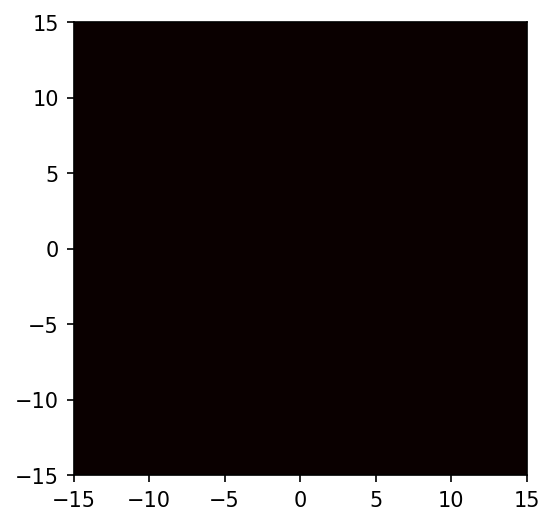

In [ ]:
# Plot one image only
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np

# Useful numbers
c = 2.998e8 # speed of light in m/s
pc = 30.857e15 # 1 parsec in m
AUcm = 1.49598e13 # AU in cm
kboltz = 1.3806503e-23 # Boltzmann constant in Si
hplanck = 6.626068e-34 # Planck constant in Si

# Definitions
path = '../r3dresults/st28gm06n052_nospikes/166_optoolmgsio/'
image = 'image_i000_phi000_0.65um.out'
distance = 1

# Chose polarisation
polarisation = 'i'   # Should be the normal image
#polarisation = 'q'   # lin1
#polarisation = 'u'   # lin2
#polarisation = 'v'   # circ

# TODO
# should be able to combine q and u for all linear polarised light

# Set column number
if polarisation == 'i':
    polar_numb = 0
if polarisation == 'q':
    polar_numb = 1
if polarisation == 'u':
    polar_numb = 2
if polarisation == 'v':
    polar_numb = 3

# Place holder for total flux density
fluxtotal = []

# Declare image object
plt.figure(dpi=150)


# Load image
# TODO save this image-loader as special polarised light loader!

# Automatically add / to end of path if it's missing
if path[-1] != '/':
    path += '/'

# Declare lists
image1d = []

# Load data
with open(path+image, 'r') as f:
    for nl,line in enumerate(f.readlines()):

        # Check if polarised image or not
        if nl == 0:
            imagesetting = int(line.strip())
        if imagesetting == 3:
            # This is correct, otherwise, load normal image
            #            
            # Row 1: image size, pixels by pixels
            if nl == 1:
                npixels_x = int(line.split()[0])
                npixels_y = int(line.split()[1])
                npixels = max([npixels_x,npixels_y])            
            # row 3: pixel size is in cm, divide by AUcm for AU
            if nl == 3:
                pixelsize_au = float(line.split()[0])/AUcm


            # row 6 onward: pixel-values, four columns
            # image.out's pixels has unit
            # erg s-1 cm-2 Hz-1 ster-1
            if nl > 5:
                if len(line.split()) > 1:
                    # Split line and take the chosen column
                    pixeldata = line.split()[polar_numb]

                    # Some rows are empty or contain space and \n, so strip them pixel data
                    # and save in image1d
                    if len(line.strip()) > 0:
                        image1d.append(float(pixeldata.strip()))

if imagesetting == 1:
    print('Not polarised, load normal image with a3d.load_images()!')
    # TODO do that here
else:
    # Continue with plotting image
    #
    # Extract some useful quantities
    # pixel size in asec (pixelsize in au and distance in pc gives distance in asec)
    pixelsize_as = pixelsize_au / distance
    #
    # Size of whole image in AU and image-axis-scales
    size_au = pixelsize_au * npixels
    axisplot  = [-0.5*size_au,0.5*size_au,-0.5*size_au,0.5*size_au]
    #
    # Extract intensity of component
    if polarisation != 'i':
        image1d = [np.abs(image1dpix) for image1dpix in image1d]
    #
    # Total flux density of the image in Jy
    # Transoform to Jy/pix and sum all
    # 1 Jy = 1e23 erg/(s cm2 Hz)
    # 1 asec = 1/(180/pi * 3600)^2 ster = 2.35044305391e-11 ster
    # 1 pixel = pixelsize_as^2  asec^2
    totalflux = sum(image1d) * 1.e23 * 2.35044305391e-11 * pixelsize_as**2
    #
    # Create 2D arrays
    image2d = np.zeros((npixels,npixels))
    image2dlog = np.zeros((npixels,npixels))
    nx,ny = 0,0
    #
    for flux in image1d:
        # Convert image1d to 2d and change unit to Jy/asec2
        image2d[nx,ny] = flux * 1.e23 * 2.35044305391e-11
        #   
        # Remove zeros before logging (1e-6 is small enough, probably)
        # Smallest number >0 is 1.1, so log10 is just larger than 0
        if image2d[nx,ny] == 0:
            image2dlog[nx,ny] = -6
        else:
            image2dlog[nx,ny] = np.log10(flux * 1.e23 * 2.35044305391e-11)
        #
        # Move nx and ny
        nx = nx + 1
        if nx == npixels_x:
            nx = 0
            ny = ny + 1
    # 
    # TODO here ends Load-image-code
    #      now we start plot-image code
    #
    vmin = np.min(image2d)
    vmax = np.mean(image2d)
    plt.imshow(
        image2d,
        origin='lower',
        extent=axisplot,
        cmap=plt.get_cmap('hot'),
        vmin=vmin,
        vmax=vmax
    )



"""

, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot'),
        vmin=vmin,
        vmax=vmax

        
        
    # Plot each image (one in linear and one log)
    fig, ax = plt.subplots(
        1,2, 
        dpi = 150, 
        num = path+image
    )
    
    im0 = ax[0].imshow(
        image2d, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot')
    )
    ax[0].set(
        title=f"{path[-4:-1]}: {image.replace('image_', '').replace('.out', '')} (Lin)", 
        xlabel='Offset (AU)',
        ylabel='Offset (AU)'
    )
            
    ax[1].imshow(
        image2dlog, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot')
    )
    ax[1].set(
        title=f"{path[-4:-1]}: {image.replace('image_', '').replace('.out', '')} (Log)", 
        xlabel='Offset (AU)',
    )

    #cb0 = plt.colorbar(im0, orientation = 'vertical',shrink=0.4,pad=0.15)
    #cb0.set_label(label = rf'Flux at {distance} pc (Jy/asec$^2$)',fontsize= 10)

    # Change figure size
fig.tight_layout()

""";



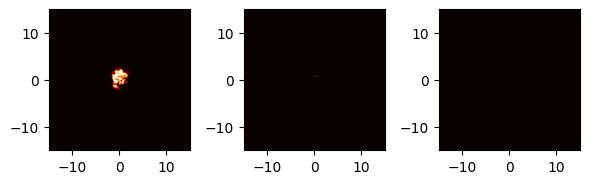

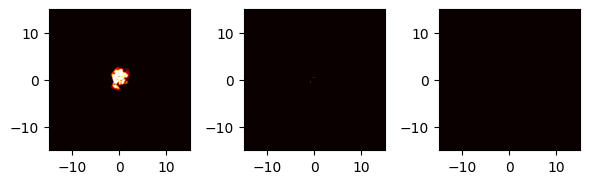

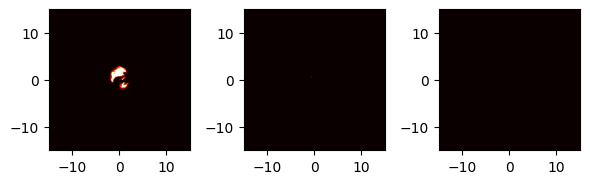

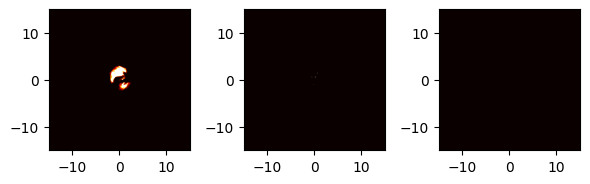

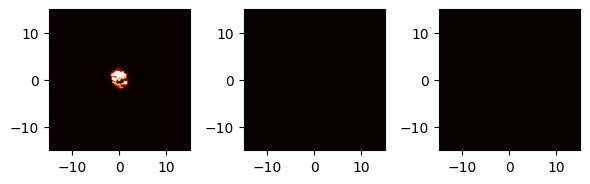

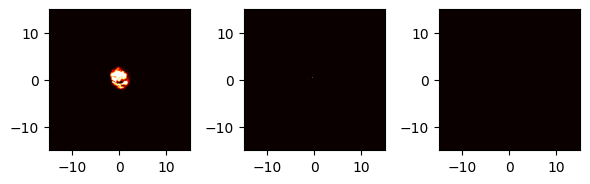

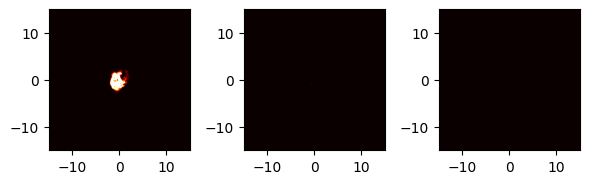

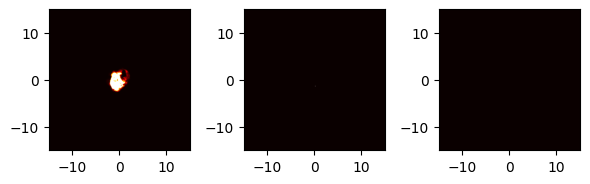

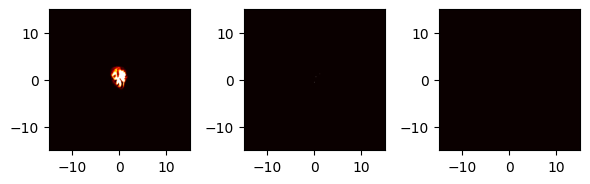

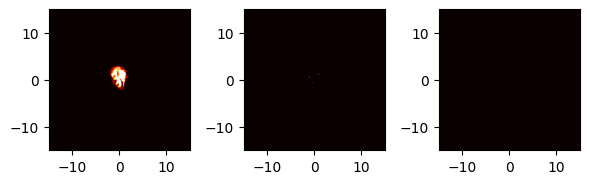

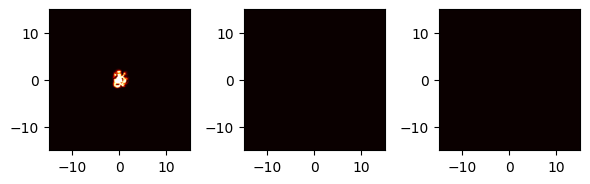

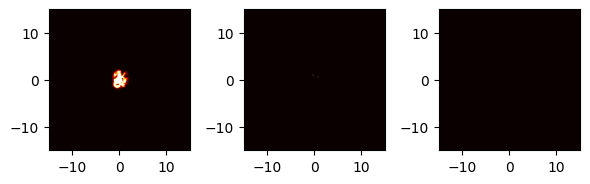

In [22]:
# Plot image, linear pol and circ pols in subplots
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np

# Useful numbers
c = 2.998e8 # speed of light in m/s
pc = 30.857e15 # 1 parsec in m
AUcm = 1.49598e13 # AU in cm
kboltz = 1.3806503e-23 # Boltzmann constant in Si
hplanck = 6.626068e-34 # Planck constant in Si

# Definitions
path = '../r3dresults/st28gm06n052_nospikes/166_optoolmgsio/'




images = [
    'image_i000_phi000_0.65um.out',
    'image_i000_phi000_0.82um.out',
    'image_i090_phi000_0.65um.out',
    'image_i090_phi000_0.82um.out',
    'image_i090_phi090_0.65um.out',
    'image_i090_phi090_0.82um.out',
    'image_i090_phi270_0.65um.out',
    'image_i090_phi270_0.82um.out',
    'image_i180_phi000_0.65um.out',
    'image_i180_phi000_0.82um.out',
    'image_i270_phi000_0.65um.out',
    'image_i270_phi000_0.82um.out',
]

for nimage,image in enumerate(images):

    distance = 1

    # List polarisations
    polarisation = [
        'Tot intensity',
        'Linear intensity',
        'Circular intensity',
    ]
    # Declare lists for image intensity, linear pol intensity and circ pol intensity
    I_intens_1d = []
    L_intens_1d = []
    V_intens_1d = []
    # Place holder for total flux density
    fluxtotal = []
    # Declare image object
    fig,ax = plt.subplots(
        1,3,
        num=nimage,
        dpi=100
    )
    # Load image
    #
    # Automatically add / to end of path if it's missing
    if path[-1] != '/':
        path += '/'
    #
    # Declare lists
    image1d = []
    # Load data
    with open(path+image, 'r') as f:
        for nl,line in enumerate(f.readlines()):

            # Check if polarised image or not
            if nl == 0:
                imagesetting = int(line.strip())
            if imagesetting == 3:
                # This is correct, otherwise, load normal image
                #            
                # Row 1: image size, pixels by pixels
                if nl == 1:
                    npixels_x = int(line.split()[0])
                    npixels_y = int(line.split()[1])
                    npixels = max([npixels_x,npixels_y])            
                # row 3: pixel size is in cm, divide by AUcm for AU
                if nl == 3:
                    pixelsize_au = float(line.split()[0])/AUcm


                # row 6 onward: pixel-values, four columns
                # image.out's pixels has unit
                # erg s-1 cm-2 Hz-1 ster-1
                if nl > 5:
                    if len(line.split()) > 1:
                        # Loop over polarisation numbers
                        # Split line and extract each column, strip from \n and make floats
                        i_pixeldata = float(line.split()[0].strip())
                        q_pixeldata = float(line.split()[1].strip())
                        u_pixeldata = float(line.split()[2].strip())
                        v_pixeldata = float(line.split()[3].strip())
                        # Save each image-combo
                        I_intens_1d.append(
                            i_pixeldata
                        )
                        L_intens_1d.append(
                            np.sqrt(q_pixeldata**2 + u_pixeldata**2)
                        )
                        V_intens_1d.append(
                            np.sqrt(v_pixeldata**2)
                        )
    if imagesetting == 1:
        raise ValueError('Not polarised, load normal image with a3d.load_images()!')
    else:
        # Continue with plotting image
        #
        # Extract some useful quantities
        # pixel size in asec (pixelsize in au and distance in pc gives distance in asec)
        pixelsize_as = pixelsize_au / distance
        #
        # Size of whole image in AU and image-axis-scales
        size_au = pixelsize_au * npixels
        axisplot  = [-0.5*size_au,0.5*size_au,-0.5*size_au,0.5*size_au]
        #
        # Total flux density of the image in Jy
        # Transoform to Jy/pix and sum all
        # 1 Jy = 1e23 erg/(s cm2 Hz)
        # 1 asec = 1/(180/pi * 3600)^2 ster = 2.35044305391e-11 ster
        # 1 pixel = pixelsize_as^2  asec^2
        #totalflux = sum(image1d) * 1.e23 * 2.35044305391e-11 * pixelsize_as**2
        #
        # Create 2D arrays
        I_image2d = np.zeros((npixels,npixels))
        L_image2d = np.zeros((npixels,npixels))
        V_image2d = np.zeros((npixels,npixels))
        nx,ny = 0,0
        #
        for i_flux,l_flux,v_flux in zip(I_intens_1d,L_intens_1d,V_intens_1d):
            # Convert image1d to 2d and change unit to Jy/asec2
            I_image2d[nx,ny] = i_flux * 1.e23 * 2.35044305391e-11
            L_image2d[nx,ny] = l_flux * 1.e23 * 2.35044305391e-11
            V_image2d[nx,ny] = v_flux * 1.e23 * 2.35044305391e-11
            #   
            # Move nx and ny
            nx = nx + 1
            if nx == npixels_x:
                nx = 0
                ny = ny + 1
        # Plot all three sub plots
        ax[0].imshow(
            I_image2d,
            origin='lower',
            extent=axisplot,
            cmap=plt.get_cmap('hot'),
            vmin=np.mean(I_image2d),
            vmax=np.max(I_image2d)*1e-1
        )
        ax[1].imshow(
            L_image2d,
            origin='lower',
            extent=axisplot,
            cmap=plt.get_cmap('hot'),
            vmin=np.min(L_image2d),
            vmax=np.mean(L_image2d)*1e-1
        )
        ax[2].imshow(
            V_image2d,
            origin='lower',
            extent=axisplot,
            cmap=plt.get_cmap('hot'),
            vmin=np.min(V_image2d),
            vmax=np.mean(V_image2d)*1e-1
        )
    fig.tight_layout()

"""
    ax[0].set(
        title=f"{path[-4:-1]}: {image.replace('image_', '').replace('.out', '')} (Lin)", 
        xlabel='Offset (AU)',
        ylabel='Offset (AU)'
    )
fig.tight_layout()
""";




In [20]:
np.max(I_image2d)

np.float64(8716723.697911572)